### Fitting standard GLM-HMM to Falkner aggression data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io as sio
import scipy.optimize
import pickle
from matplotlib.pyplot import axes

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize, analysis

import seaborn as sns
sns.set_context("talk")

In [3]:
featuresShortlist1 = ["proximity",'resident2intruder head-head', 'resident2intruder head-tti','resident2intruder head2head angle', 'resident2intruder head2tti angle', "intruder2resident head2centroid angle","resident centroid roc 500 ms", "intruder centroid roc 500 ms",
   "resident tti2head", "intruder tti2head", "resident tailbase2head angle", "intruder tailbase2head angle"]
featuresShortlist2 = ["proximity",'resident2intruder head-head','resident2intruder head-tti','resident2intruder head2centroid angle',"resident centroid roc 500 ms","intruder centroid roc 500 ms"]
# ARE THERE HEAD TO TAIL AND HEAD TO HEAD ANLGES?

In [4]:
animals = ['29L_','3095_','3096_','3097_','30B_','30L_','30R2_','4013_','4014_','4015_','4016_','91R2_']
days = ['d1_balbc','d2_balbc','d3_balbc','d4_balbc','d5_balbc','d6_balbc','d7_balbc','d8_balbc','d9_mCD1']
obsDays = []
sessions = ['_t1','_t2','_t3']

In [5]:
# All sessions together
sessInd = [0]
for animal in ['29L_']:
    for day in days:
        for sess in sessions:
            if (day == 'd1_balbc' and sess =='_t1'):
                y = np.load('../data_falkner/' + f'{animal+day+sess}_aggr_labels.npy')
                x = np.load(f'../data_falkner/{animal+day+sess}_featuresShortlist1.npy')
                sessInd.append(y.shape[0])
            else:
                tempY = np.load('../data_falkner/' + f'{animal+day+sess}_aggr_labels.npy')
                tempX = np.load(f'../data_falkner/{animal+day+sess}_featuresShortlist1.npy')
                y = np.concatenate((y,tempY))
                x = np.concatenate((x,tempX))
                sessInd.append(tempY.shape[0] + int(sessInd[-1]))
sessInd = np.array(sessInd)


In [6]:
# Set hyperparameters
N = x.shape[0] # number of data/time points 
K = 3
C = 2 # number of observation classes
D = x.shape[1] # number of GLM inputs (regressors)

inits = 41 # set the number of initializations - Iris has 50
maxiter = 300 # maximum number of iterations of EM to allow for each fit - Iris has 250
tol = 1e-3

# store values for each initialization
lls_all = np.zeros((inits,maxiter))
real_GLMHMMs = np.zeros((inits),dtype=object)

# fit the model for each initialization
for i in range(inits):
    print(i)
    real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
    # initialize the weights
    A_init,w_init,_ = real_GLMHMMs[i].generate_params(weights=['GLM',-0.2,1.2,x,y,1])
    # fit the model                     
    lls_all[i,:],A,w,pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Number of top matching lls within threshold for indirect pathway:  1


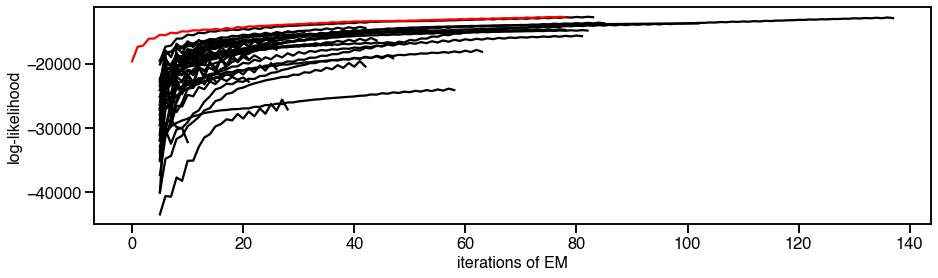

In [7]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 4)
topixs = visualize.plot_loglikelihoods(lls_all,0.15,axes,startix=5)
print('Number of top matching lls within threshold for indirect pathway: ', len(topixs))

In [ ]:
import pickle
bestix = find_best_fit(lls_all) # find the initialization that led to the best fit
best_GLMHMM = real_GLMHMMs[bestix]
pickle.dump(best_GLMHMM, open('../data_falkner/29L_all_bestGLMHMM.pickle', 'wb'))

In [ ]:
print(best_GLMHMM.A)

[[9.96654562e-01 2.54827750e-03 7.97160587e-04]
 [5.24916007e-03 9.91822522e-01 2.92831751e-03]
 [1.52457935e-03 4.20487702e-03 9.94270544e-01]]


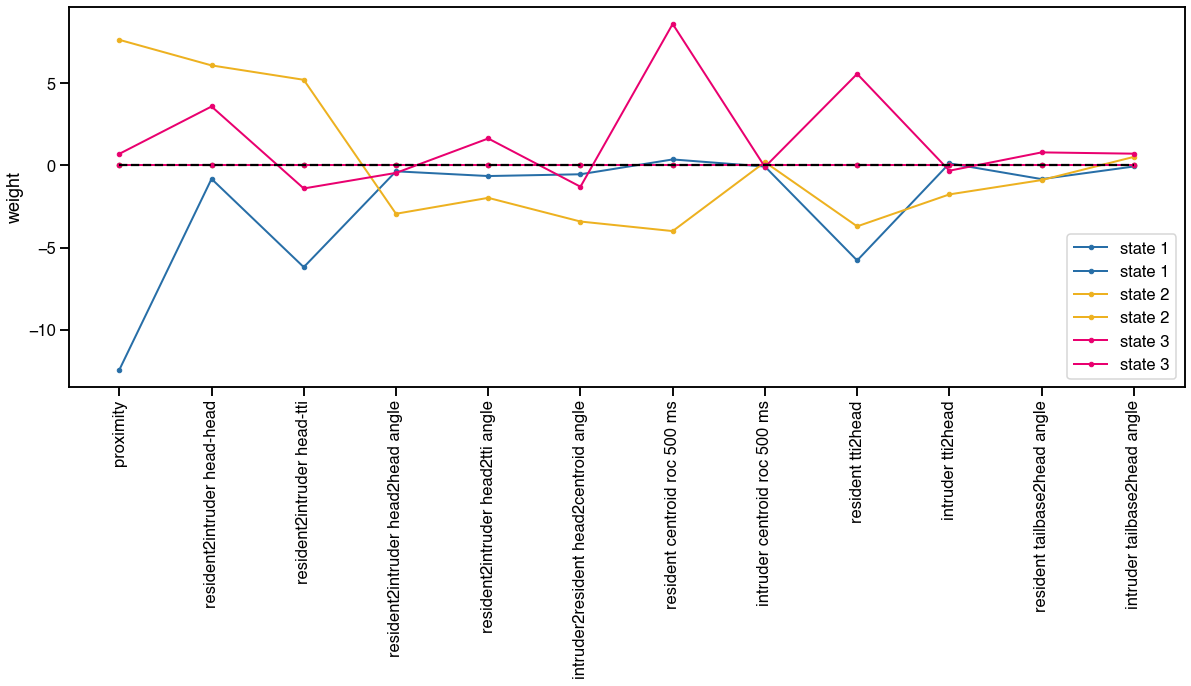

In [11]:
# plot the inferred weights probabilities
fig, axes = plt.subplots(1,1)
fig.set_size_inches(20, 7)
colors = np.array([[39,110,167],[237,177,32],[233,0,111],[176,100,245]])/255
legend = ['state 1', 'state 2', 'state 3']
visualize.plot_weights(best_GLMHMM.w,axes,xlabels=featuresShortlist1,switch=False,style='.-',
             color=colors,error=None,label=legend)
axes.legend()


d1_balbc
[    0 21023 42158 63256]
Number of top matching lls within threshold for indirect pathway:  1
d2_balbc
[    0 21072 42486 63028]
Number of top matching lls within threshold for indirect pathway:  1
d3_balbc
[    0 21189 42277 65045]
Number of top matching lls within threshold for indirect pathway:  1
d4_balbc
[    0 20910 41146 61091]
Number of top matching lls within threshold for indirect pathway:  1
d5_balbc
[    0 20503 41180 61641]
Number of top matching lls within threshold for indirect pathway:  1
d6_balbc
[    0 19983 40813 61666]
Number of top matching lls within threshold for indirect pathway:  1
d7_balbc
[    0 21002 43162 63969]
Number of top matching lls within threshold for indirect pathway:  1
d8_balbc
[    0 21059 42246 65176]
Number of top matching lls within threshold for indirect pathway:  1
d9_mCD1
[    0  9577 19086 28574]
Number of top matching lls within threshold for indirect pathway:  1


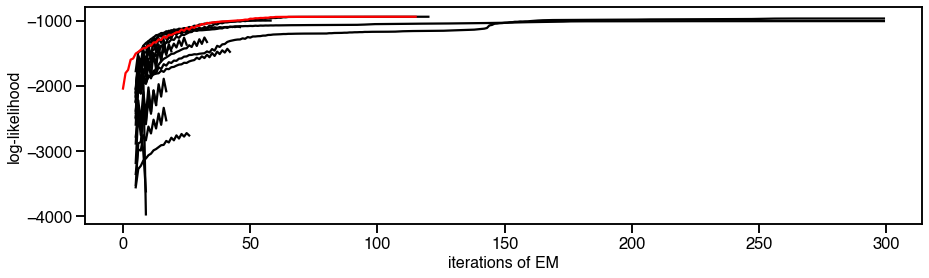

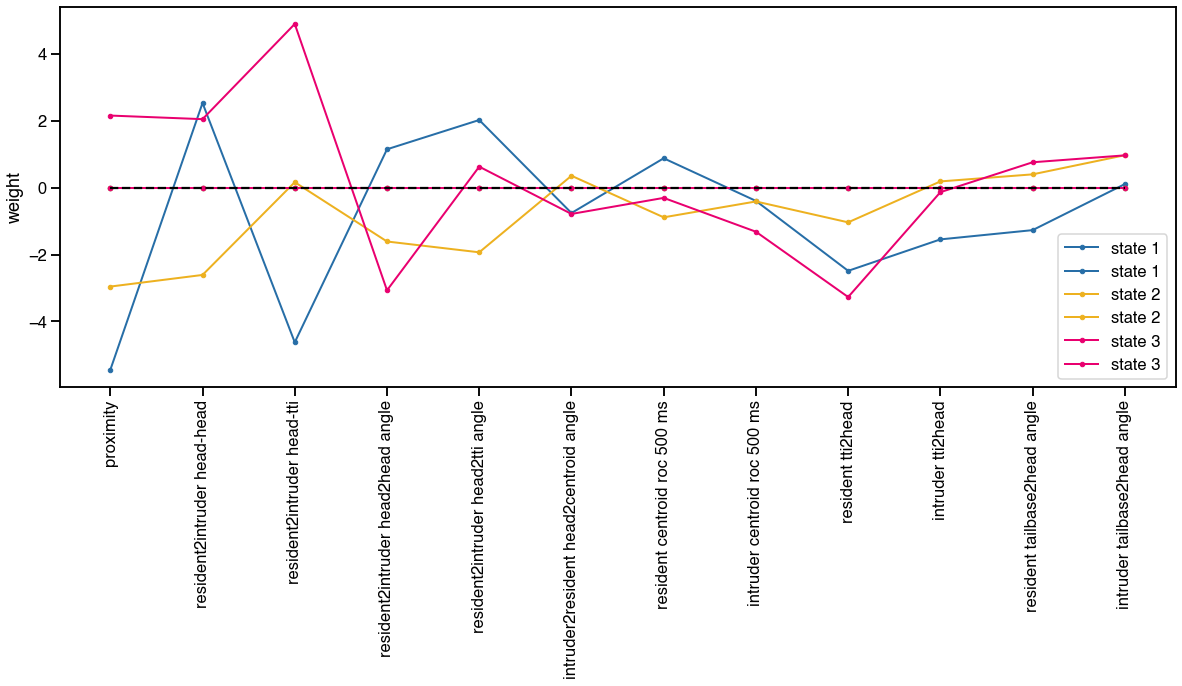

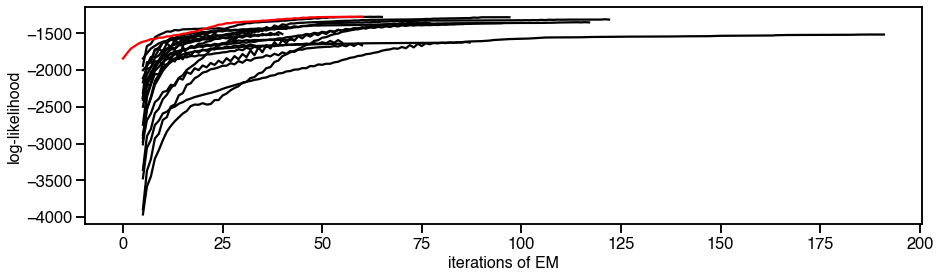

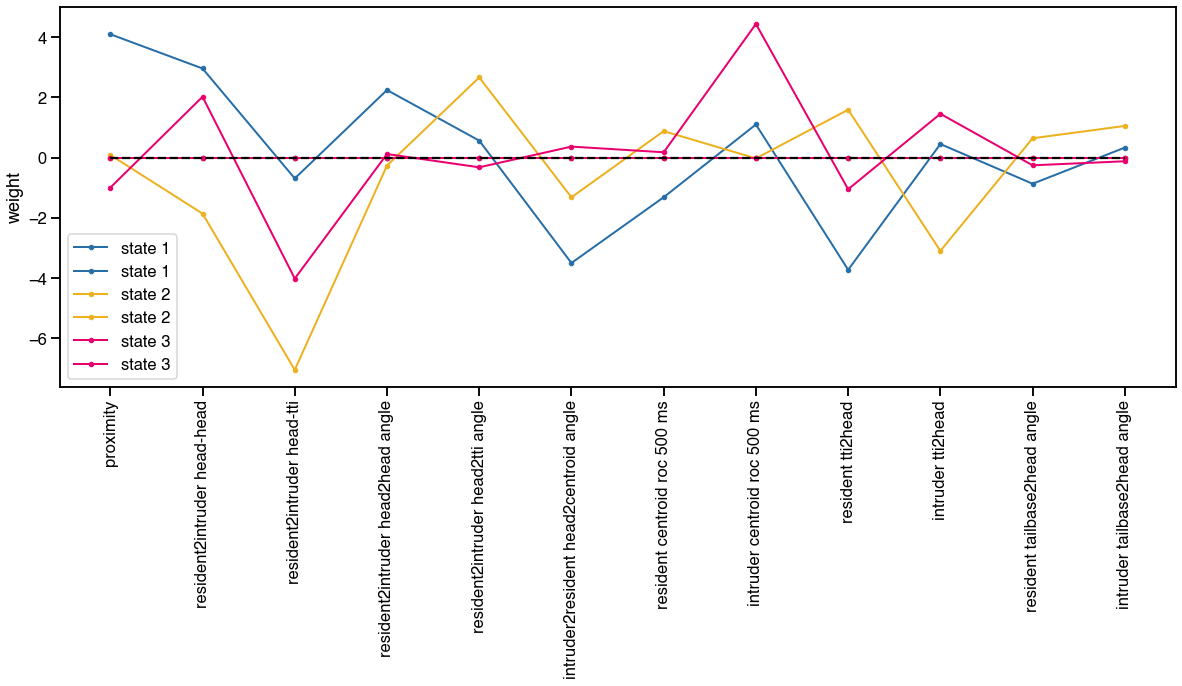

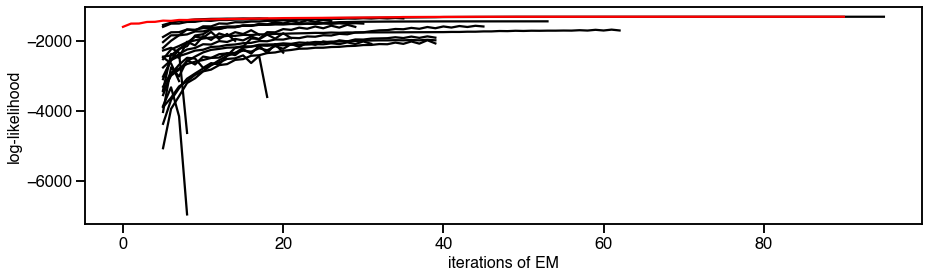

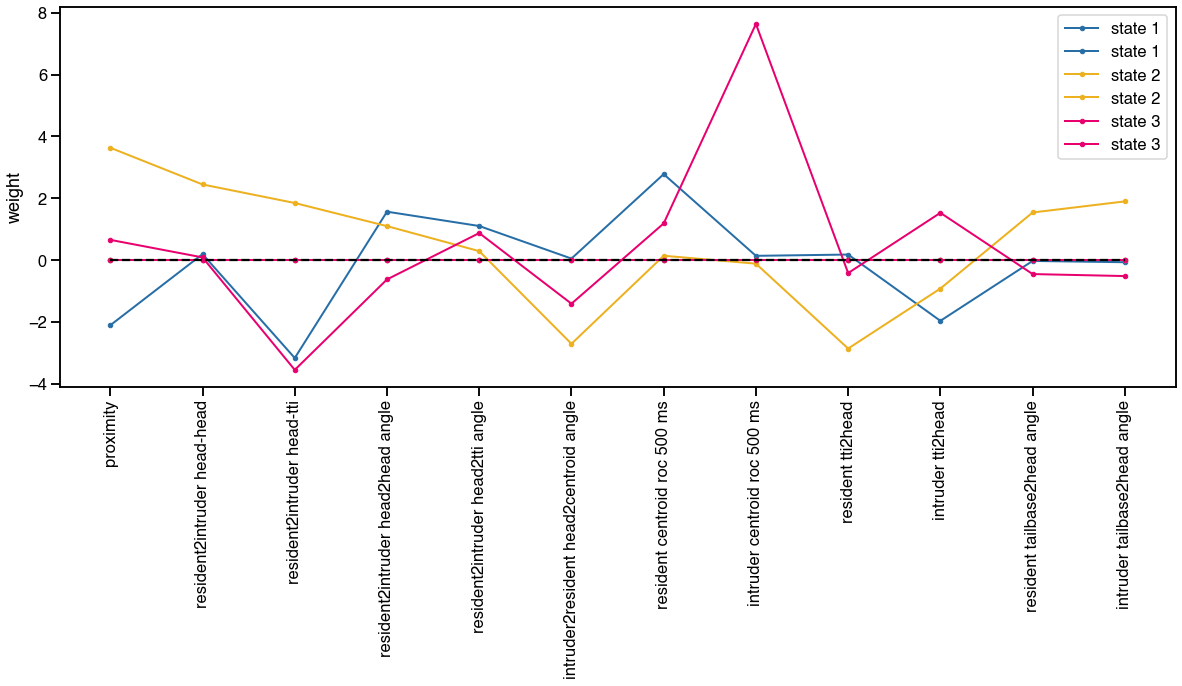

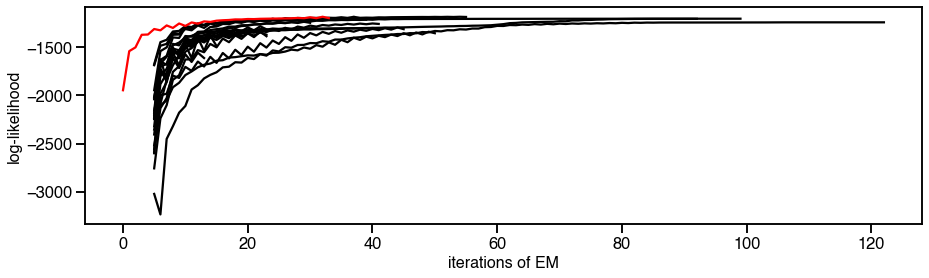

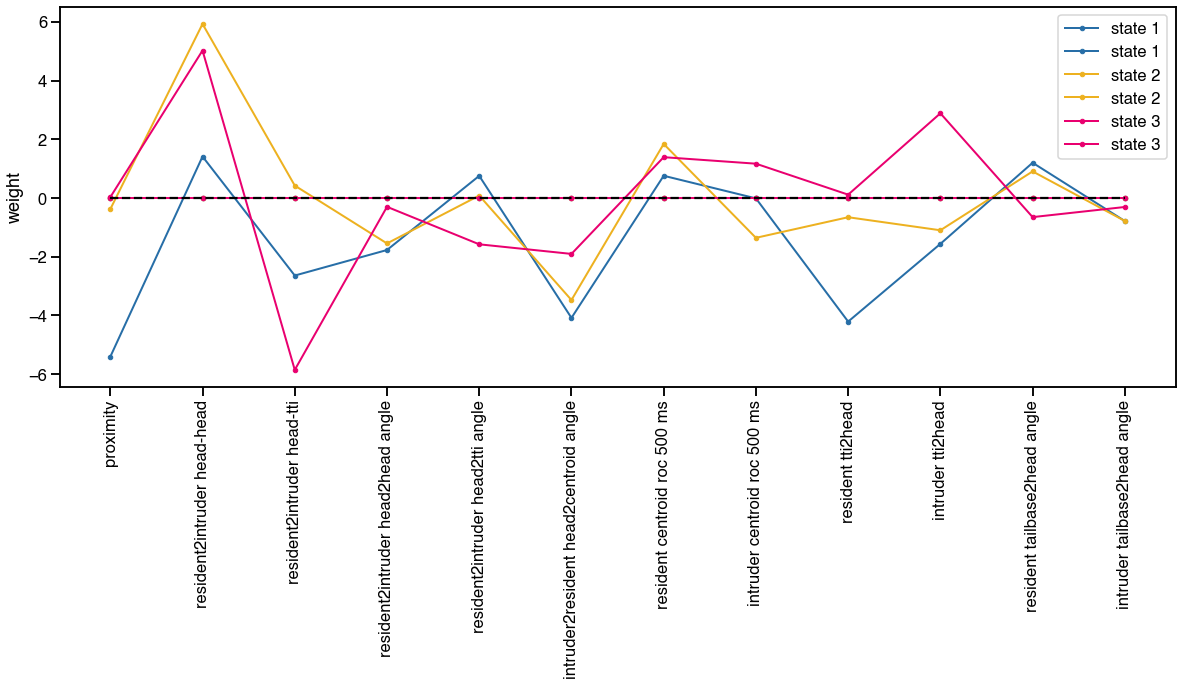

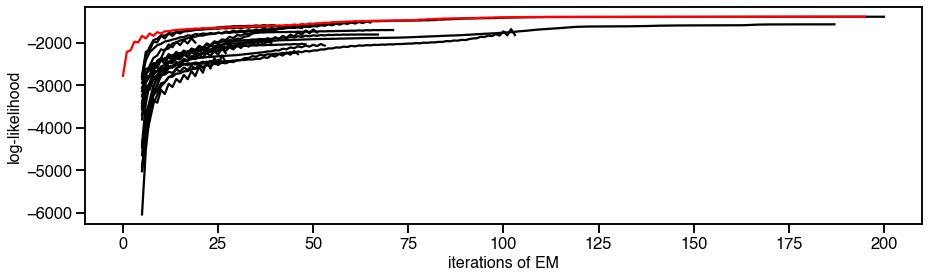

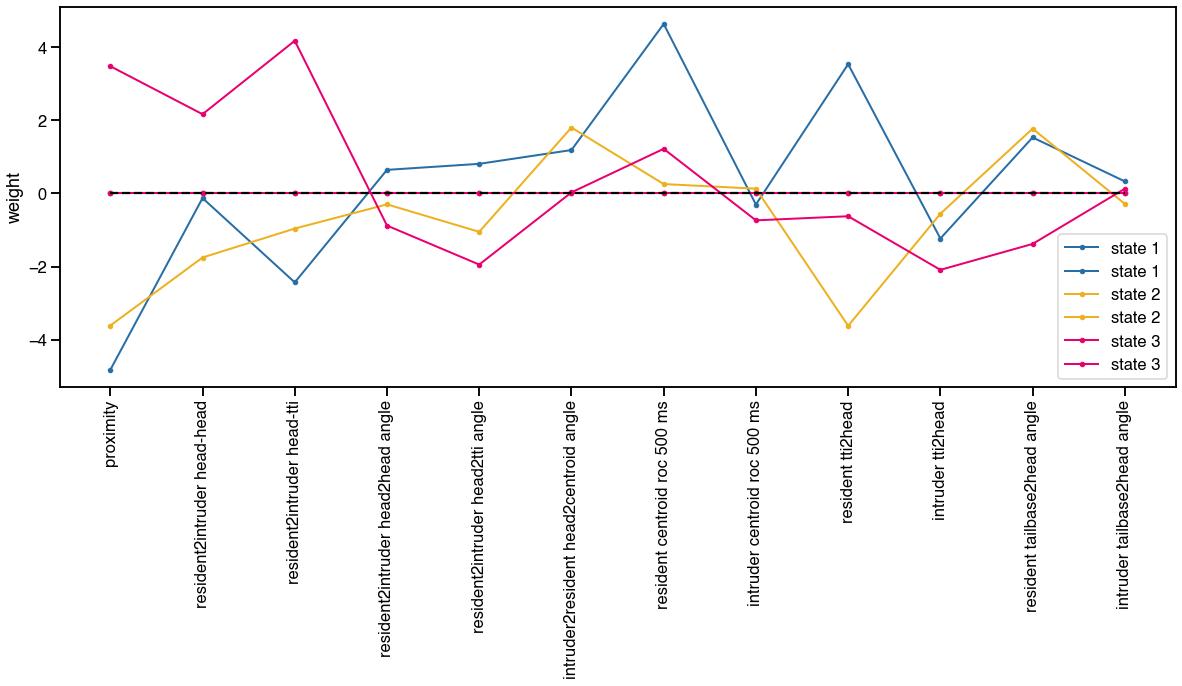

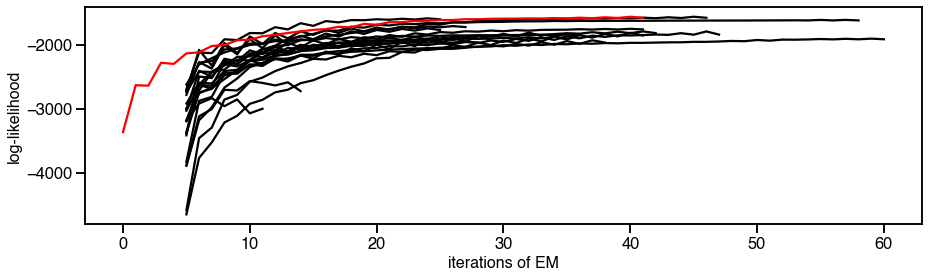

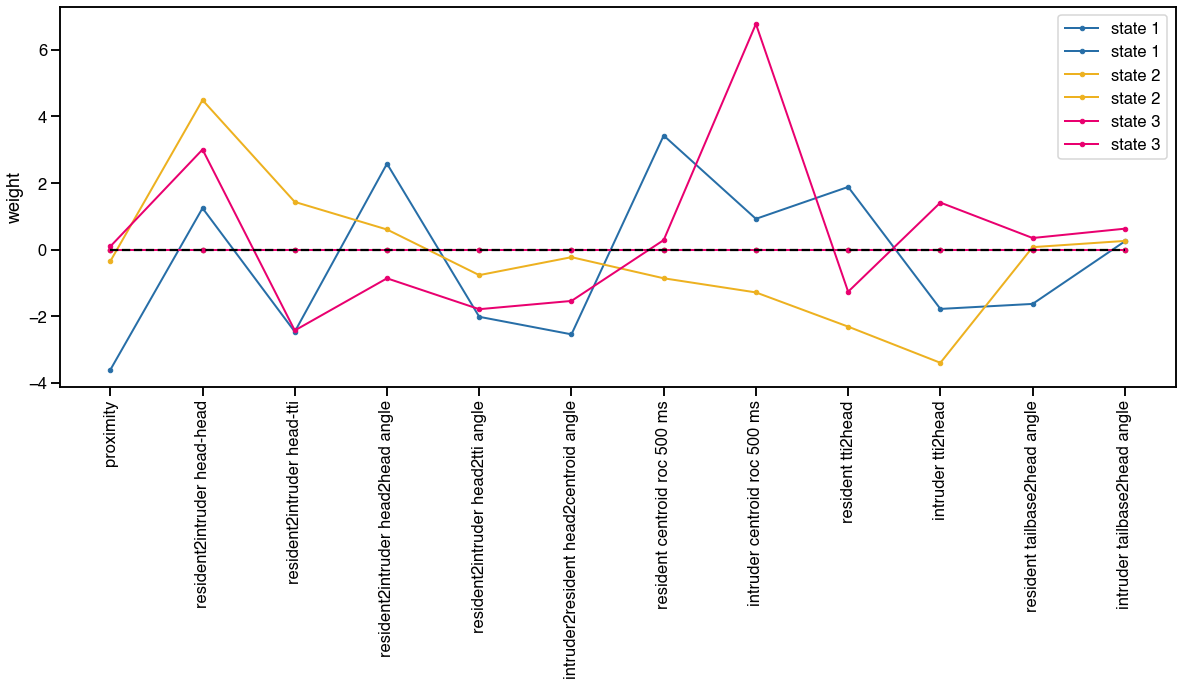

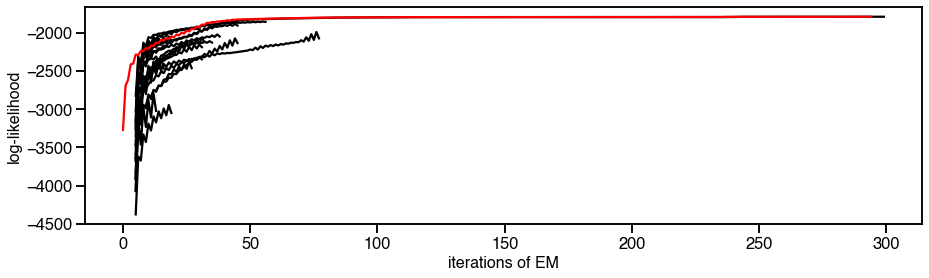

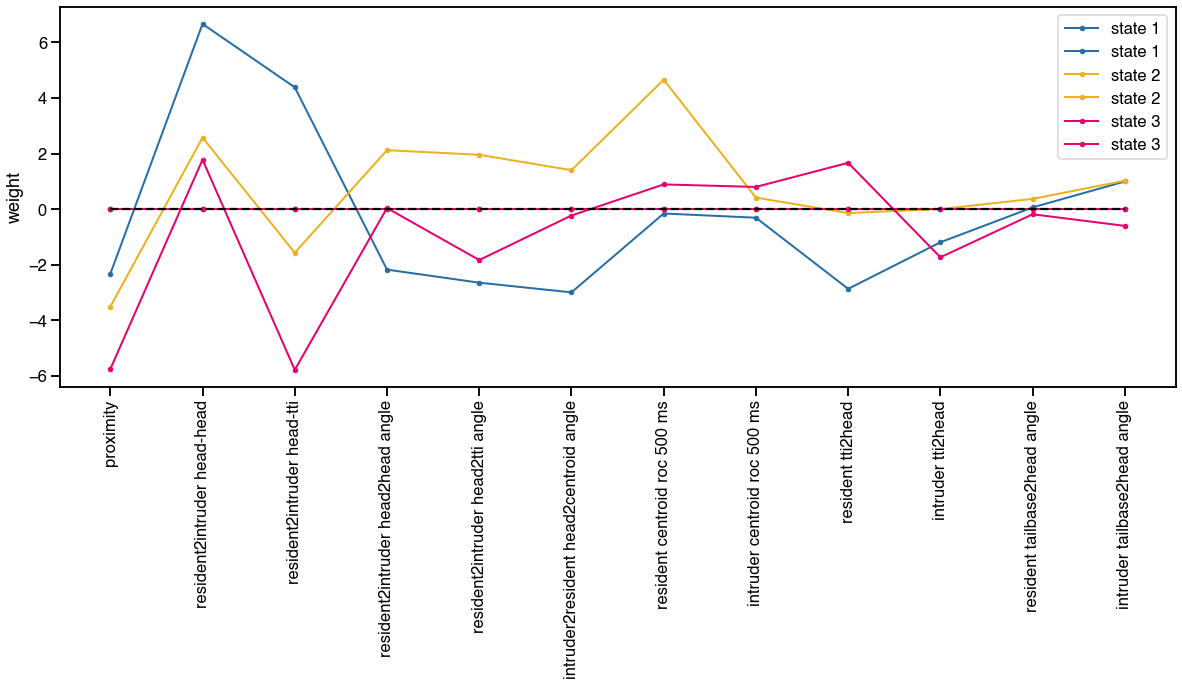

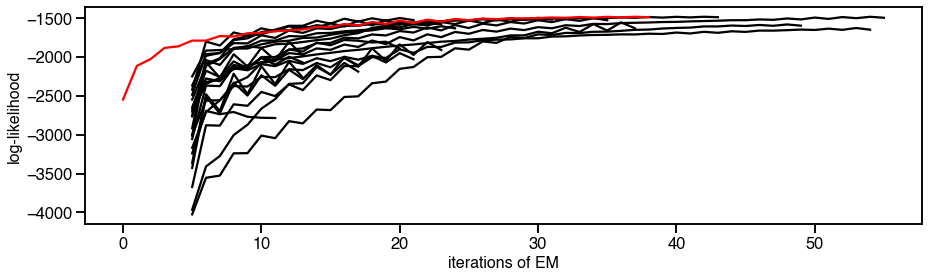

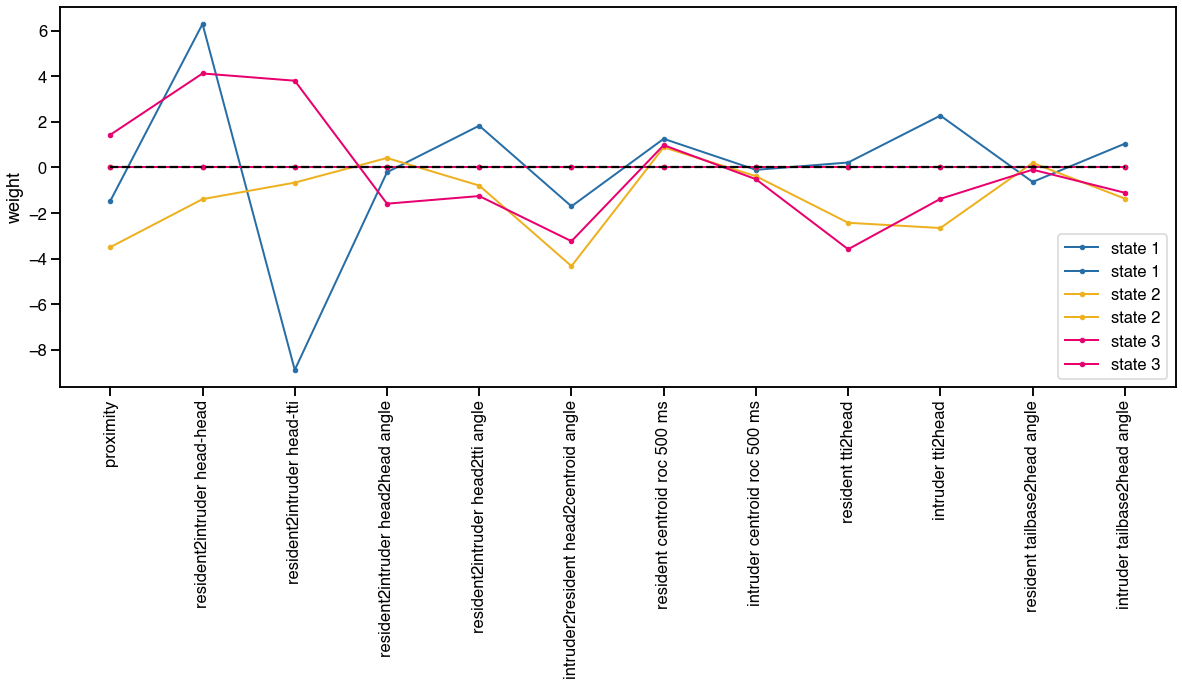

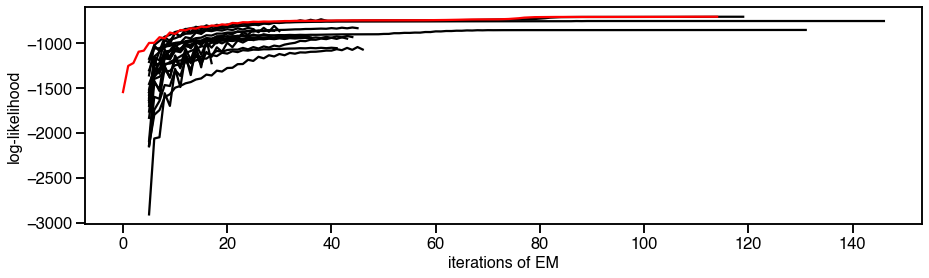

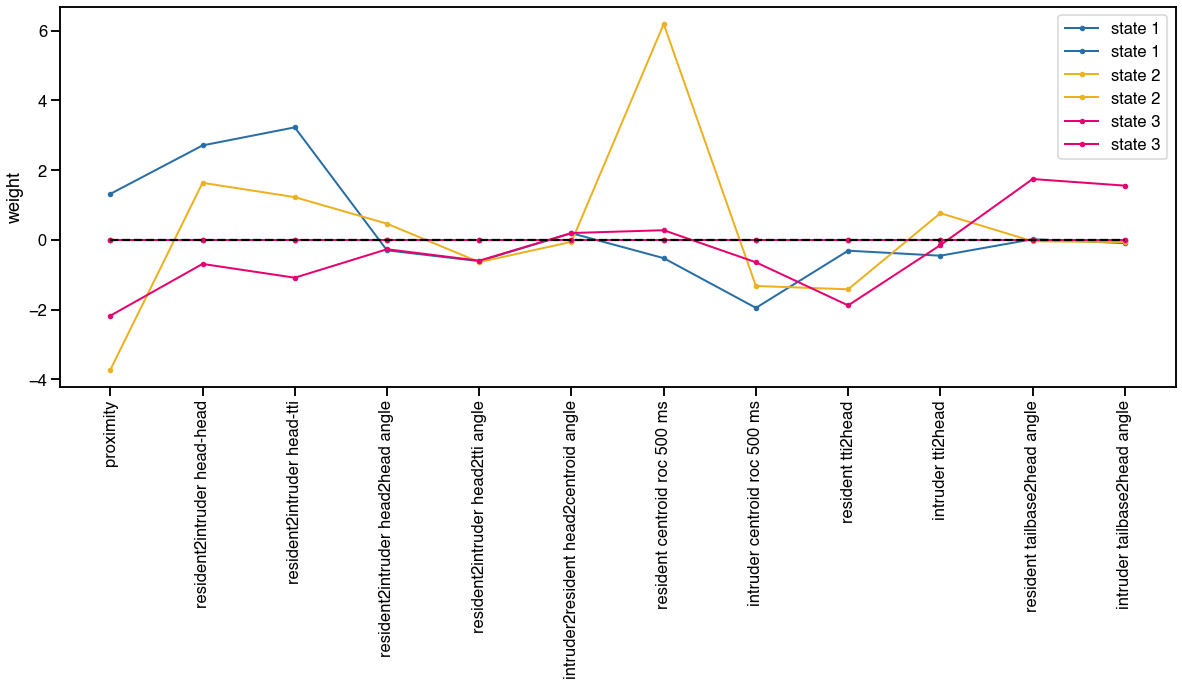

In [11]:
# Each day separate GLM-HMM with K=3
for animal in ['29L_']:
    for day in days:
        print(day)

        sessInd = [0]
        for sess in sessions:
            if (sess =='_t1'):
                y = np.load('../data_falkner/' + f'{animal+day+sess}_aggr_labels.npy')
                x = np.load(f'../data_falkner/{animal+day+sess}_featuresShortlist1.npy')
                sessInd.append(y.shape[0])
            else:
                tempY = np.load('../data_falkner/' + f'{animal+day+sess}_aggr_labels.npy')
                tempX = np.load(f'../data_falkner/{animal+day+sess}_featuresShortlist1.npy')
                y = np.concatenate((y,tempY))
                x = np.concatenate((x,tempX))
                sessInd.append(tempY.shape[0] + int(sessInd[-1]))
        sessInd = np.array(sessInd)
        print(sessInd)

                # Set hyperparameters
        N = x.shape[0] # number of data/time points 
        K = 3
        C = 2 # number of observation classes
        D = x.shape[1] # number of GLM inputs (regressors)

        inits = 21 # set the number of initializations - Iris has 50
        maxiter = 300 # maximum number of iterations of EM to allow for each fit - Iris has 250
        tol = 1e-3

        # store values for each initialization
        lls_all = np.zeros((inits,maxiter))
        real_GLMHMMs = np.zeros((inits),dtype=object)

        # fit the model for each initialization
        for i in range(inits):
            real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
            # initialize the weights
            A_init,w_init,_ = real_GLMHMMs[i].generate_params(weights=['GLM',-0.2,1.2,x,y,1])
            # fit the model                     
            lls_all[i,:],A,w,pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
        
        fig, axes = plt.subplots(1,1)
        fig.set_size_inches(15, 4)
        topixs = visualize.plot_loglikelihoods(lls_all,0.15,axes,startix=5)
        print('Number of top matching lls within threshold for indirect pathway: ', len(topixs))

        bestix = find_best_fit(lls_all) # find the initialization that led to the best fit
        best_GLMHMM = real_GLMHMMs[bestix]
        pickle.dump(best_GLMHMM, open(f'../data_falkner/29L_{day}_bestGLMHMM_K={K}.pickle', 'wb'))

        # plot the inferred weights probabilities
        fig, axes = plt.subplots(1,1)
        fig.set_size_inches(20, 7)
        colors = np.array([[39,110,167],[237,177,32],[233,0,111],[176,100,245]])/255
        legend = ['state 1', 'state 2', 'state 3']
        visualize.plot_weights(best_GLMHMM.w,axes,xlabels=featuresShortlist1,switch=False,style='.-',
                    color=colors,error=None,label=legend)
        axes.legend()
        

In [13]:
# LOOK AT % AGGRESSION LABELS IN EACH STATE

In [14]:
# PLOT WEIGHT OF SINGLE FEATURE ACROSS DAYS